In [2]:
## Import packages
import numpy as np
from scipy.optimize import minimize
from scipy import integrate

from astropy.io import fits, ascii
from astropy import units as u

from astropy.coordinates import angles
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy.cosmology import LambdaCDM
from astropy.table import Table
from astropy.visualization import quantity_support
quantity_support()

import matplotlib.pyplot as plt

# $f_\text{cen}$ in previous studies

|         Study        | Optical |     SZ/X-ray    | Sample size | Well-centered fraction |
|:--------------------:|:-------:|:---------------:|:-----------:|:----------------------:|
|  Saro et al. (2015)  |   DES   |     SPT (SZ)    |      22     |           63%          |
| Rykoff et al. (2016) |   DES   |   XMM (X-ray)   |      29     |           85%          |
|  Oguri et al. (2018) |   HSC   |   XMM (X-ray)   |      50     |           68%          |
|  Zhang et al. (2019) |   SDSS  | Chandra (X-ray) |     144     |          67.8%         |
| Our study            |   HSC   |  ACT (SZ)       |     186     |          75.4%         |

# Load in cluster catalogs

## ACT catalog

(Opening the catalog as a table; see: https://docs.astropy.org/en/stable/io/unified.html#fits)

In [3]:
ACT_cat = Table.read('DR5_cluster-catalog_v1.1.fits', hdu = 1)

column = np.asarray(ACT_cat['decDeg'])
print(f'There are {len(column)} ACT clusters.')

There are 4195 ACT clusters.


## HSC catalog
Each row has 6 values: RA (degrees), Dec (degrees), z_cl, N_mem, logMs, and z_bcg; in that order. z_bcg = -1.0 indicates that the cluster has no identified BCG.

HSC_cat omits the last column of the data file, which lists the ID of a cluster.

In [4]:
## filter out low-richness clusters
use_starmask = True
use_richness_cut = True

if use_starmask:
    HSC_cat_orig = np.loadtxt('camira_s19a_wide_sm_v1.txt', usecols=(0,1,2,3,4,5)) 
    HSC_cat_IDs_orig = np.loadtxt('camira_s19a_wide_sm_v1.txt', dtype='str', usecols=(6)) 
else:
    HSC_cat_orig = np.loadtxt('camira_s19a_wide_v1.txt', usecols=(0,1,2,3,4,5)) 
    HSC_cat_IDs_orig = np.loadtxt('camira_s19a_wide_v1.txt', dtype='str', usecols=(6)) 

if use_richness_cut:
    good_richness = HSC_cat_orig[:,3] > 15
    HSC_cat = HSC_cat_orig[good_richness]
    HSC_cat_IDs = HSC_cat_IDs_orig[good_richness]
else:
    HSC_cat = HSC_cat_orig
    HSC_cat_IDs = HSC_cat_IDs_orig

print(f'There are {HSC_cat.shape[0]} HSC clusters.')

There are 5860 HSC clusters.


## Create SkyCoords

In [5]:
## SkyCoord objects for ACT and HSC
ACT_coords = SkyCoord(ra=ACT_cat['RADeg'] * u.degree, 
                      dec=ACT_cat['decDeg'] * u.degree, 
                      frame='icrs')
HSC_coords = SkyCoord(ra=HSC_cat[:,0] * u.degree, 
                      dec=HSC_cat[:,1] * u.degree, 
                      frame='icrs')

# convert coords to (-pi, pi) radians
act_ra = ACT_coords.ra.wrap_at(180 * u.deg).radian
act_dec = ACT_coords.dec.radian
hsc_ra = HSC_coords.ra.wrap_at(180 * u.deg).radian
hsc_dec = HSC_coords.dec.radian

## Define some boolean masks and print catalog counts

In [6]:
## Some ACT catalog counts

in_hsc_footprint = ACT_cat['footprint_HSCs19a']
print('Number of ACT clusters in HSC footprint: ' + 
      str(np.sum(in_hsc_footprint)))

has_hsc_counterpart = ACT_cat['CAMIRA']
print('Number of ACT clusters cross-matched with CAMIRA: ' + 
      str(np.sum(has_hsc_counterpart)))

print('Number of ACT clusters in HSC footprint (but not flagged as having an HSC counterpart): ' + 
      str(np.sum(in_hsc_footprint & ~has_hsc_counterpart)))

position_from_cam = (ACT_cat['opt_positionSource'] == 'CAMIRA')
print('Number of ACT clusters with positions from CAMIRA: ' + 
      str(np.sum(position_from_cam)))

print()

print('Number of ACT clusters in SDSS footprint: ' + 
      'N/A')

has_sdss_counterpart = ACT_cat['RM'] 
print('Number of ACT clusters cross-matched with RM (SDSS): ' + 
      str(np.sum(has_sdss_counterpart)))

position_from_sdss = (ACT_cat['opt_positionSource'] == 'RM')
print('Number of ACT clusters with positions from RM (SDSS): ' + 
      str(np.sum(position_from_sdss)))

print() 

in_des_footprint = ACT_cat['footprint_DESY3']
print('Number of ACT clusters in DES footprint: ' + 
      str(np.sum(in_des_footprint)))

has_des_counterpart = ACT_cat['RMDESY3']
print('Number of ACT clusters cross-matched with RM (DES): ' + 
      str(np.sum(has_des_counterpart)))

position_from_des = (ACT_cat['opt_positionSource'] == 'RMDESY3') | \
                    (ACT_cat['opt_positionSource'] == 'RMDESY3ACT')
print('Number of ACT clusters with positions from RM (DES): ' + 
      str(np.sum(position_from_des)))

Number of ACT clusters in HSC footprint: 185
Number of ACT clusters cross-matched with CAMIRA: 212
Number of ACT clusters in HSC footprint (but not flagged as having an HSC counterpart): 17
Number of ACT clusters with positions from CAMIRA: 61

Number of ACT clusters in SDSS footprint: N/A
Number of ACT clusters cross-matched with RM (SDSS): 992
Number of ACT clusters with positions from RM (SDSS): 482

Number of ACT clusters in DES footprint: 1845
Number of ACT clusters cross-matched with RM (DES): 1689
Number of ACT clusters with positions from RM (DES): 1206


# Centering offsets (ACT-HSC)

Below, `get_physical_sep` calculates the physical separation between two objects at the same redshift.

In [7]:
def get_physical_sep(cosmo, theta, z):
    '''
    
    For two objects at the same redshift, calculate their physical separation 
    R as R = theta * d_A, where theta is angular separation (in radians) and 
    d_A is angular distance.
    
    ARGUMENTS
    ----------
    cosmo: model for cosmology; e.g. astropy.cosmology.LambdaCDM(...)
    theta: angular separation; should be a Quantity 
    z: redshift
    
    '''
    
    theta = theta.to(u.rad) / u.rad
    return theta * cosmo.angular_diameter_distance(z)

Note: Let $d_p$ be proper distance. Since $d_p \propto c/H_0$, $d_p$ as a function of $h$ (using $h \equiv \frac{H_0}{100 \text{ km/s/Mpc}}$) is $d_p(h) = h^{-1} d_p(h=1)$.

In [38]:
## Testing get_physical_sep + cosmo.comoving_distance

h = 0.7
temp_cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)
temp_angle = 2.5 * u.arcmin
temp_z = 0.6
print(get_physical_sep(temp_cosmo, temp_angle, temp_z))

# theta_grid = np.linspace(0, 6, 50) * u.arcmin
# temp_offsets = get_physical_sep(temp_cosmo, theta_grid, z=0.3)

# fig = plt.figure(figsize=(10,7))
# plt.plot(theta_grid, temp_offsets, label='fixed z')
# plt.plot(theta_grid, np.ones(50) / h, label='offset=1 Mpc/h')
# plt.xlabel('Angle (arcminutes)')

# plt.legend()
# plt.show()

def LOS_distance_diff(cosmo, z1, z2):
    '''

    Returns the difference in line-of-sight distance between redshifts
    z1 and z2. Assumes z2 > z1.
    
    '''
    
    return np.round(cosmo.comoving_distance(z2) - cosmo.comoving_distance(z1), 1)

#LOS_distance_diff(temp_cosmo, .30, .32)

1.0028237229131338 Mpc


In [8]:
## Plot physical offset as a function of (theta, z)

# theta_grid = np.linspace(0., 5, 50)
# z_grid = np.linspace(0, 1.4, 50)
# theta_grid,z_grid = np.meshgrid(theta_grid, z_grid)
# theta_grid *= u.arcmin

# temp_offsets = get_physical_sep(temp_cosmo, theta_grid.ravel(), z_grid.ravel())
# temp_offsets = temp_offsets.reshape(theta_grid.shape)

# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(X=theta_grid, Y=z_grid, Z=temp_offsets, label="Offsets")
# ax.plot_surface(X=theta_grid, Y=z_grid, Z=np.ones(temp_offsets.shape) / h, \
#                 label="Offset = 1 Mpc / h")
# ax.set_xlabel('theta (arcmin)')
# ax.set_ylabel('redshift')
# ax.set_zlabel('physical offset (Mpc)')

# plt.show()

# Modeling the offset distribution

See Oguri et al (2018), equation 9. Below, `offset_model` models the probability distribution of offsets, and `objective_fn` is the likelihood function.

In [32]:
def prob_dens_well_centered(x, sigma1):
    '''
    A model for the offset distribution for well-centered clusters. See
    the documentation for offset_model for a description.
    
    
    ARGUMENTS
    ---------
    x: physical offset
    sigma1: characteristic offset for well-centered clusters
    
    '''
    
    return (x / sigma1**2) * np.exp(-x**2 / (2*sigma1**2))

def prob_dens_mis_centered(x, sigma2):
    '''
    A model for the offset distribution for miscentered clusters. See
    the documentation for offset_model for a description.
    
    ARGUMENTS
    ---------
    x: physical offset
    sigma2: characteristic offset for miscentered clusters
    
    '''
    
    return (x / sigma2**2) * np.exp(-x**2 / (2*sigma2**2))

def offset_model(x, f_cen, sigma1, sigma2):
    '''
    
    A two-component model for the centering offset distribution. Returns 
    the probability density at a given offset. All arguments are in Mpc.
    
    This is equation 9 in the CAMIRA catalog paper (Oguri et al. 2018).
    Both the well-centered population and the miscentered population are
    modeled with a Rayleigh distribution.

    ARGUMENTS
    ---------
    x: physical offset
    f_cen: fraction of well-centered clusters
    sigma1: characteristic offset for well-centered clusters
    sigma2: characteristic offset for miscentered clusters
    
    '''
    
    prob_dens_well = prob_dens_well_centered(x, sigma1)
    prob_dens_mis = prob_dens_mis_centered(x, sigma2)
    
    return f_cen * prob_dens_well + (1 - f_cen) * prob_dens_mis

def offset_model_fixed_sig1(x, f_cen, sigma2, sigma1=0.1):
    '''
    
    Same as offset_model, except sigma1 is a fixed value. 
    All arguments are in Mpc.
    

    ARGUMENTS
    ---------
    x: physical offset
    f_cen: fraction of well-centered clusters
    sigma2: characteristic offset for miscentered clusters
    sigma1: characteristic offset for well-centered clusters; default
    value is 0.1 Mpc
    
    '''
    
    prob_dens_well = prob_dens_well_centered(x, sigma1)
    prob_dens_mis = prob_dens_mis_centered(x, sigma2)
    
    return f_cen * prob_dens_well + (1 - f_cen) * prob_dens_mis

def objective_fn(params, offsets):
    '''
    
    Given the model parameters and the set of offsets, compute
    the objective as a log likelihood.
    
    ARGUMENTS
    ----------
    params: tunable parameters in offset_model
    offsets: set of physical offsets (Mpc; same as offset_model)
    
    '''
    
    f_cen, sig1, sig2 = params
    probs = offset_model(offsets, f_cen, sig1, sig2)
    
    obj = -np.sum(np.log(probs)) # maximizes log likelihood
    return obj

def objective_fn_fixed_sig1(params, offsets, fixed_sig1):
    '''
    
    Given the model parameters and the set of offsets, compute
    the objective as a log likelihood.
    
    ARGUMENTS
    ----------
    params: tunable parameters in offset_model
    offsets: set of physical offsets (Mpc; same as offset_model)
    fixed_sig1: fixed value of sigma1
    
    '''
    
    f_cen, sig2 = params
    probs = offset_model_fixed_sig1(offsets, f_cen, sig2, sigma1=fixed_sig1)
    
    obj = -np.sum(np.log(probs)) # maximizes log likelihood
    return obj

# Cross-matching HSC and ACT clusters

Below, we perform a cross-match between the two catalogs.

## Create the sample

In [10]:
# idx (length=4195) indexes into HSC_coords
idx, d2d, d3d = ACT_coords.match_to_catalog_sky(HSC_coords)

## Calculate physical offsets
h = 0.7
cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)

angular_sep = ACT_coords.separation(HSC_coords[idx])
# ACT_redshifts = ACT_cat['redshift']
HSC_redshifts = HSC_cat[:,2][idx]
physical_sep = get_physical_sep(cosmo, angular_sep, HSC_redshifts)

# impose upper limit on offsets
limit = 1 * u.Mpc / h

def remove_duplicates(idx, d2d, d3d):
    '''
    This function aims to remove duplicates from the results of an 
    asymmetric cross-match.
    
    Given idx, d2d, and d3d from astropy's match_to_catalog_sky function,
    return the 'good' indices in idx as a boolean array. (Here, 'bad' means
    that an index in idx is matched to an object that already has a better 
    match in idx.)
    
    For example: if idx = (8, 8, 8) and d2d = (0.1, 0.3, 0.04), then we 
    accept the third element in idx and reject the two others. This 
    function then returns (False, False, True). 
    
    ARGUMENTS
    ---------
    idx, d2d, d3d: returns of astropy's match_to_catalog_sky function
    
    '''
    
    unique_idx, counts = np.unique(idx, return_counts=True)
    repeated_idxs = unique_idx[np.where(counts > 1)] # idxs appearing in idx multiple times
    not_duplicate = np.ones(idx.shape)
        
    for rep_idx in repeated_idxs:
        locs = np.where(idx == rep_idx)[0] # rep_idx's locations in idx (n=4195)
        locs = locs[physical_sep[locs] < limit] # remove matches whose offsets are too large
        if len(locs) < 2: continue
        best_loc = locs[0]
        
        for loc in locs:
            if d2d[loc] < d2d[best_loc]: best_loc = loc
        for loc in locs:        
            if loc != best_loc: not_duplicate[loc] = 0
            print(f'Cluster matched with HSC idx {rep_idx} (d2d = {np.round(d2d[loc],3)}):')
            print(ACT_cat[loc]['name'])
            print(f'ACT index (ie loc in idx): {loc}')

        print()
    
    return not_duplicate == 1

## Cross match with independent method

In [11]:
print('List of duplicates:')
not_duplicate = remove_duplicates(idx, d2d, d3d)
has_warning = (ACT_cat['warnings'] != '')
within_radius = (physical_sep < limit)
in_crossmatch = not_duplicate & ~has_warning & within_radius
offsets_Mpc = physical_sep[in_crossmatch] # takes subset of all 4195 offsets

print(f'Number of ACT clusters within the preliminary matching radius: {np.sum(within_radius)}')
print(f'Size of final sample: {np.sum(in_crossmatch)}')

List of duplicates:
Cluster matched with HSC idx 5728 (d2d = 0.036 deg):
ACT-CL J2343.7+0016
ACT index (ie loc in idx): 4098
Cluster matched with HSC idx 5728 (d2d = 0.01 deg):
ACT-CL J2343.7+0018
ACT index (ie loc in idx): 4099

Number of ACT clusters within the preliminary matching radius: 193
Size of final sample: 186


## Plot duplicates

In [12]:
## Plot duplicates in the sample

# fig = plt.figure(figsize=(10,6))
# fig.patch.set_facecolor('white')

# pair1_act_inds = [4098, 4099]
# pair1_hsc_ind = 5728

# plt.plot(act_ra[pair1_act_inds[0]], act_dec[pair1_act_inds[0]], 
#         marker='.', markersize=20, linestyle='None', \
#         label=ACT_cat[pair1_act_inds[0]]['name'] + ' (rejected)', c='r')
# plt.plot(act_ra[pair1_act_inds[1]], act_dec[pair1_act_inds[1]], 
#         marker='.', markersize=20, linestyle='None', \
#         label=ACT_cat[pair1_act_inds[1]]['name'] + ' (accepted)', c='g')
# plt.plot(hsc_ra[pair1_hsc_ind], hsc_dec[pair1_hsc_ind], marker='x', markersize=20, \
#         linestyle='None', label="Match in HSC (" + HSC_cat_IDs_orig[pair1_hsc_ind] + ")", c='b')

# plt.xlabel('RA (rad)')
# plt.gca().invert_xaxis()
# plt.ylabel('Dec (rad)')
# plt.title('A pair of ACT clusters matched to the same HSC cluster', pad=25)

# plt.legend()
# plt.show()

## Compute offsets and model the distribution

In [34]:
## optimization + tests for injecting/removing offsets

# (a test on how f_cen varies) 
# remove the x largest offsets
remove_offsets = False
if remove_offsets:
    num_removed = 5
    
    old_offsets_Mpc = sorted(offsets_Mpc)
    offsets_Mpc = old_offsets_Mpc[:-num_removed]

    f_excluded = num_removed / len(old_offsets_Mpc)
    print(f'Percent of offsets excluded: {np.round(f_excluded * 100, 2)}%')

## Fit the model
physical_offsets = offsets_Mpc.value # "offsets" is unitless
sample_size = len(physical_offsets)

# (a test on how f_cen varies) 
# inject large offsets into the distribution
inject_offsets = False
if inject_offsets:
    num_injected = 20
    fake_offsets = np.linspace(0.5, 1.2, num=num_injected)
    physical_offsets = np.concatenate((physical_offsets, fake_offsets))
    print(f'len(physical_offsets): {len(physical_offsets)}')

use_fixed_sig1 = False
if use_fixed_sig1:
    fixed_sig1 = 0.15
    sig1_best = fixed_sig1
    
    initial_guess = (0.75, 0.17)
    best_guess = minimize(fun=objective_fn_fixed_sig1, x0=initial_guess, \
                    args=(physical_offsets, fixed_sig1), method='L-BFGS-B', \
                          bounds=((0., 1), (0.01, 1.)))
    f_best, sig2_best = best_guess.x
else:
    initial_guess = (0.75, 0.15, 0.35)
    best_guess = minimize(fun=objective_fn, x0=initial_guess, args=(physical_offsets), \
                         method='L-BFGS-B', bounds=((0., 1), (1e-4, 0.3), (0.1, 1.)))
    f_best, sig1_best, sig2_best = best_guess.x

print(best_guess)

      fun: -80.65445451897705
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00013074,  0.00033396, -0.0003979 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([0.61572568, 0.11841274, 0.33587734])


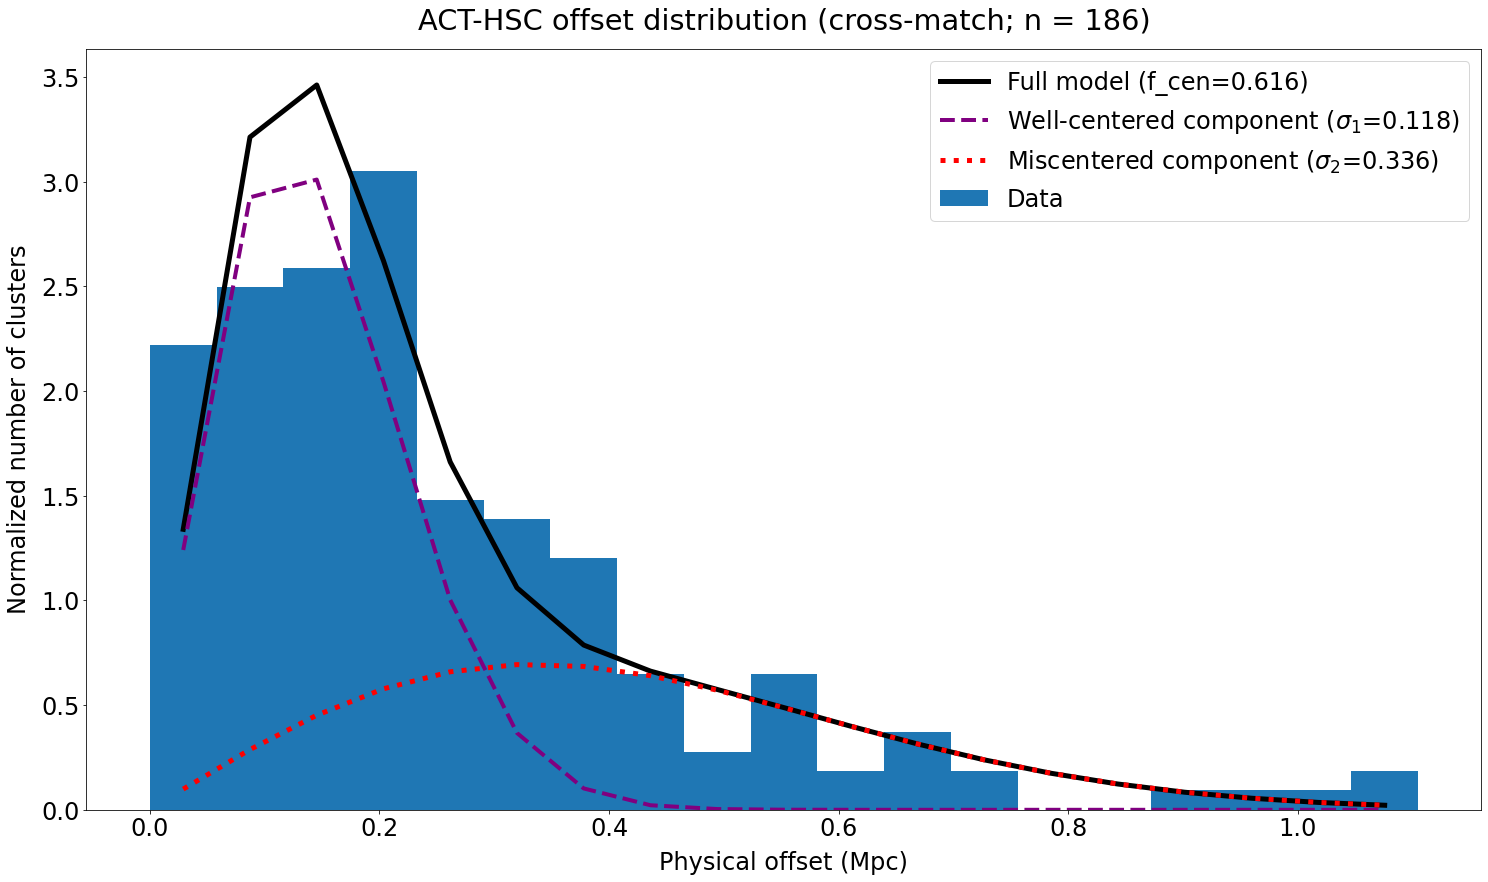

In [36]:
## set global font size
plt.rcParams.update({'font.size':24})

## Plot offset distribution (cross-match)
fig = plt.figure(figsize=(25,14))
fig.patch.set_facecolor('white')

plot_title = f"ACT-HSC offset distribution (cross-match; n = {sample_size}"
if remove_offsets:
    plot_title += f"; {np.round(f_excluded * 100,1)}% excluded"
if inject_offsets:    
    plot_title += f"; {num_injected} injected"
plt.title(plot_title + ")", pad=20)

## Data sample
num_bins = 20
max_offset = np.max(physical_offsets)
bins = np.linspace(0, max_offset, num=num_bins)
hist = plt.hist(physical_offsets, bins=bins, \
                label=f"Data", density=True)
plt.xlabel("Physical offset (Mpc)", labelpad=10)
plt.ylabel("Normalized number of clusters", labelpad=10)

## Model
x_axis = (hist[1][:-1] + hist[1][1:]) / 2 # midpoints of histogram bins
# plot full model
norm_factor_full = 1 / \
        integrate.quad(offset_model, 0, max_offset, args=(f_best, sig1_best, sig2_best))[0]

# plot the full model
plt.plot(x_axis, norm_factor_full*offset_model(x_axis, f_best, sig1_best, sig2_best), \
    label=f"Full model (f_cen={np.round(f_best,3)})", color='black', linewidth=5)

# plot the model's two components separately
if use_fixed_sig1:
    plt.plot(x_axis, norm_factor_full*f_best*prob_dens_well_centered(x_axis, sig1_best),
         label=f"Well-centered component ($\sigma_1$={np.round(sig1_best,3)}, fixed)", \
         color='purple', linestyle='--', linewidth=4)
else:
    plt.plot(x_axis, norm_factor_full*f_best*prob_dens_well_centered(x_axis, sig1_best),
         label=f"Well-centered component ($\sigma_1$={np.round(sig1_best,3)})", \
         color='purple', linestyle='--', linewidth=4)
plt.plot(x_axis, norm_factor_full*(1-f_best)*prob_dens_mis_centered(x_axis, sig2_best), 
         label=f"Miscentered component ($\sigma_2$={np.round(sig2_best,3)})", \
         color='red', linestyle=':', linewidth=5)

plt.legend()
plt.savefig("Figures/Modeling_Offset_Distro/Rayleigh_model/HSC_crossmatch.png", bbox_inches='tight')
plt.show()

# Get IDs of clusters in crossmatch

From below: Offsets for clusters only in my cm:
[0.64867942 1.0849587  0.65074321 1.10470057 0.88377362] Mpc

Useful lists:
- List of ACT clusters in the crossmatch (len=186): `ACT_cat['name'][in_crossmatch]`
- List of HSC IDs in the crossmatch (len=186): `HSC_cat_IDs[idx[in_crossmatch]]`
- List of offsets in the crossmatch (len=186): `offsets_Mpc`

In [15]:
index_in_cm = np.where(np.isclose(offsets_Mpc / u.Mpc, 0.8838, atol=1e-3))[0][0]

In [16]:
print(f'Index: {index_in_cm}')
print(f'Physical separation: {np.round(offsets_Mpc[index_in_cm],4)}\n')

print('HSC name:')
print(HSC_cat_IDs[idx[in_crossmatch]][index_in_cm])
print('ra, dec')
print(f"{HSC_cat[idx[in_crossmatch]][index_in_cm][0]}" + ', ' + f"{HSC_cat[idx[in_crossmatch]][index_in_cm][1]}")

print()

print('ACT name:')
print(ACT_cat['name'][in_crossmatch][index_in_cm])
print('ra, dec')
print(f"{ACT_cat['RADeg'][in_crossmatch][index_in_cm]}" + ', ' + f"{ACT_cat['decDeg'][in_crossmatch][index_in_cm]}")

Index: 154
Physical separation: 0.8838 Mpc

HSC name:
C19a1sW11629
ra, dec
222.480008, 0.843226

ACT name:
ACT-CL J1450.0+0049
ra, dec
222.52333676219158, 0.8249908026061182


In [17]:
HSC_cat[idx[in_crossmatch]][index_in_cm]

array([222.480008,   0.843226,   0.382   ,  28.364   ,  12.302   ,
        -1.      ])

# Match with merging population

In general, are miscentered (i.e. large offset) clusters merging? 

First, we assign the labels of "well-centered" and "miscentered" to the cross-match clusters. For example, assume $f_{cen}=0.75$. If a cluster's centering offset is in the 75th percentile of all offsets in the sample, then it is miscentered; otherwise, it is well-centered.

In [18]:
well_centered_cutoff = np.percentile(physical_offsets, 100*f_best)
print(f'well_centered_cutoff: {np.round(well_centered_cutoff, 3)} Mpc')
is_well_centered = [(offset < well_centered_cutoff) for offset in physical_offsets]
is_well_centered = np.asarray(is_well_centered)

well_centered_cutoff: 0.331 Mpc


Then, we flag the merging clusters in the cross-match. ('cm' is an abbreviation for cross-match.)

In [19]:
HSC_cat_IDs_cm = HSC_cat_IDs[idx[in_crossmatch]]

HSC_merging_cat = ascii.read('S19A_mergers_S21Amethod/combined/mergingcluster.dat')
merging_cluster_IDs = set(HSC_merging_cat['col1'])

# flag merging clusters in crossmatch
is_merging_cm = [(ID in merging_cluster_IDs) for ID in HSC_cat_IDs_cm]
is_merging_cm = np.asarray(is_merging_cm)
# flag merging clusters in full HSC catalog
is_merging_full = [(ID in merging_cluster_IDs) for ID in HSC_cat_IDs] 
is_merging_full = np.asarray(is_merging_full)

In [20]:
is_well_centered_merging = is_well_centered & is_merging_cm
is_miscentered_merging = ~is_well_centered & is_merging_cm

merging_frac_well = np.sum(is_well_centered_merging) / np.sum(is_well_centered)
merging_frac_mis = np.sum(is_miscentered_merging) / np.sum(~is_well_centered)
merging_frac_cm = np.sum(is_merging_cm) / sample_size
merging_frac_full = np.sum(is_merging_full) / len(is_merging_full)

print(f'Fraction of well-centered clusters that are merging: {np.round(merging_frac_well, 2)}') 
print(f'Fraction of miscentered clusters that are merging: {np.round(merging_frac_mis, 2)}') 
print(f'Fraction of clusters in cross-match that are merging: {np.round(merging_frac_cm, 2)}') 
print(f'Fraction of clusters in HSC catalog that are merging: {np.round(merging_frac_full, 2)}') 
print(f'(Note: this HSC catalog has use_starmask={use_starmask} and use_richness_cut={use_richness_cut}.)')

Fraction of well-centered clusters that are merging: 0.1
Fraction of miscentered clusters that are merging: 0.22
Fraction of clusters in cross-match that are merging: 0.13
Fraction of clusters in HSC catalog that are merging: 0.16
(Note: this HSC catalog has use_starmask=True and use_richness_cut=True.)


In [21]:
mis_frac_of_merging = np.sum(is_miscentered_merging) / np.sum(is_merging_cm)

print(f'Fraction of merging clusters (in the cross-match) that are miscentered: {np.round(mis_frac_of_merging, 2)}') 

Fraction of merging clusters (in the cross-match) that are miscentered: 0.42


In [22]:
print(f'Number of well-centered merging clusters: {np.sum(is_well_centered & is_merging_cm)}')
print(f'Number of well-centered clusters: {np.sum(is_well_centered)}')
print(f'Number of miscentered merging clusters: {np.sum(~is_well_centered & is_merging_cm)}')
print(f'Number of miscentered clusters: {np.sum(~is_well_centered)}')

Number of well-centered merging clusters: 14
Number of well-centered clusters: 140
Number of miscentered merging clusters: 10
Number of miscentered clusters: 46


## Summary table

|               | Merging | Not merging | Total |
|---------------|:-------:|:-----------:|:-----:|
| Well-centered | 14      | 126         | 140   |
| Miscentered   | 10      | 36          | 46    |
| Total         | 24      | 162         | 186   |

# Tests on cross-match

### ACT completeness wrt HSC

We calculate the fraction of HSC clusters with ACT counterparts (as a function of HSC richness); in other words, we want to characterize how well ACT detects HSC clusters.

Steps:
- create new HSC cluster catalog that excludes clusters outside of ACT's footprint
- flag which HSC clusters have ACT counterparts
- preliminary plot: make 1D scatter-plot of HSC clusters (with richness on the y-axis); green=has match, red=none
- more formal plot: create richness bins; within each bin, count the # of clusters with matches

We create `HSC_cat_more`, which adds two columns to `HSC_cat`: the 7th column indicates if the HSC cluster is in ACT's footprint (we do this imprecisely), and the 8th column indicates if the HSC cluster has a match in ACT.

In [23]:
HSC_in_ACT_area = (HSC_cat[:,1] < 30)
HSC_in_ACT_area = np.expand_dims(HSC_in_ACT_area, axis=1)
HSC_has_match = [ind in set(idx[in_crossmatch]) for ind in list(range(len(HSC_cat)))]
HSC_has_match = np.expand_dims(HSC_has_match, axis=1)
                             
HSC_cat_more = np.hstack((HSC_cat, HSC_in_ACT_area, HSC_has_match))

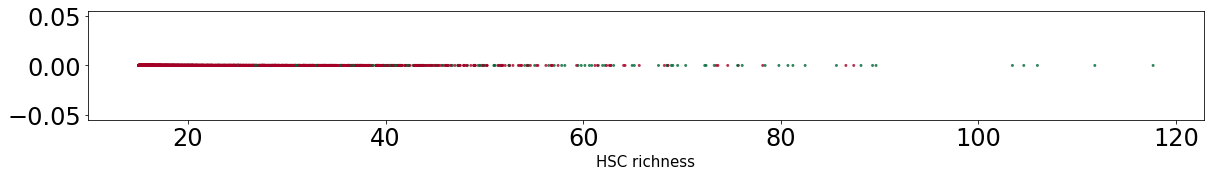

In [24]:
## Plot every HSC richness in the ACT footprint; green data points correspond to
## clusters with an ACT match, red data points correspond to those without one.
richnesses_in_area = HSC_cat_more[:,3][HSC_cat_more[:,6] == 1]
richnesses_in_area_and_match = HSC_cat_more[:,3]\
        [(HSC_cat_more[:,7] == 1) & (HSC_cat_more[:,6] == 1)]

in_area_and_match = HSC_cat_more[:,7][HSC_cat_more[:,6] == 1]

fig = plt.figure(figsize=(20,2))
plt.scatter(richnesses_in_area, np.zeros_like(richnesses_in_area), s=4, alpha=0.7, \
            c=in_area_and_match, cmap='RdYlGn')
plt.xlabel('HSC richness', size=15)
plt.show()

In [25]:
## Plot histograms of 1. all richnesses in the ACT area and 2. richnesses of cross-match clusters in the area

# fig = plt.figure(figsize=(10,6))

# bins = plt.hist(richnesses_in_area, label='# of HSC clusters (ACT footprint only)')
# plt.hist(richnesses_in_area_and_match, bins = bins[1], label='# of HSC clusters (in footprint + has match)')
# plt.xlabel('HSC richness')
# plt.ylabel('# of clusters')
# plt.yscale('log')

# plt.legend()
# plt.show()

In [26]:
def get_completeness(min_lambda, max_lambda):
    '''
    Given the set of HSC clusters in the ACT footprint that have richness 
    in the range [min_lambda, max_lambda], return the fraction of them that 
    has a match in the ACT catalog. (This is an estimate of ACT's completeness 
    for certain richnesses.)
    
    PARAMETERS
    ----------
    min_lambda: minimum bound on HSC richness
    max_lambda: maximum bound on HSC richness
    
    '''
    
    in_richness_range = (HSC_cat_more[:, 3] >= min_lambda) & \
        (HSC_cat_more[:, 3] <= max_lambda) & (HSC_cat_more[:, 6] == True)
    
    has_match = (HSC_cat_more[:, 7] == True) & in_richness_range
    
    if np.sum(in_richness_range) > 0:
        return np.sum(has_match) / np.sum(in_richness_range)
    else:
        print(f"Warning: There aren't any HSC clusters in the richness range ({min_lambda}, {max_lambda}).")
        print("Returning 0.")
        return 0

Listing completeness fractions for given richness ranges:
(15, 25): 0.0062
(25, 35): 0.0625
(35, 45): 0.1667
(45, 55): 0.3205
(55, 65): 0.4839
(65, 75): 0.6471
(75, 85): 0.7778
(85, 95): 0.6667
(95, 105): 1.0
(105, 115): 1.0
(115, 125): 1.0


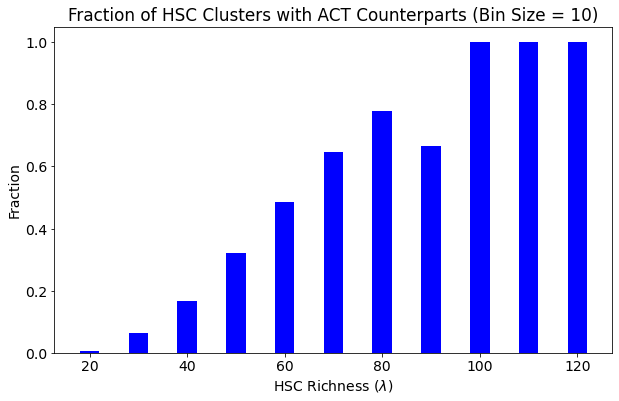

In [31]:
plt.figure(figsize=(10,6))

# x_locs = []
# fracs = []
step = 10

print('Listing completeness fractions for given richness ranges:')
for min_lambda in range(15, 125, step):
    frac = get_completeness(min_lambda, min_lambda+step)
    print(f'({min_lambda}, {min_lambda+step}): {np.round(frac,4)}')
    
    plt.bar(min_lambda + step/2, frac, color='blue', width=4)
#     x_locs.append(min_lambda + step/2)
#     fracs.append(frac)
    
#plt.hist(fracs, bins=range(15, 125, step))

plt.rcParams.update({'font.size':14})


plt.xlabel('HSC Richness ($\lambda$)')    
plt.ylabel('Fraction')
plt.title('Fraction of HSC Clusters with ACT Counterparts (Bin Size = 10)')
plt.show()

### Test ACT's cross-matching (nemo)

In [30]:
def _posRecFitFunc(snr, snrFold, pedestal, norm):
    """Fitting function used for position recovery offset (') in terms of fixed_SNR - see
    positionRecovery/positionRecoveryTestDriver.py.
    
    NOTE: Don't use this directly - call checkCrossMatch instead.
    
    """
    return norm*np.exp(-snr/snrFold)+pedestal
    
def checkCrossMatch(distArcmin, fixedSNR, z = None, addRMpc = 0.5, fitSNRFold = 1.164, fitPedestal = 0.685,
                    fitNorm = 38.097):
    """Checks the cross match offset between a cluster detection and an external catalog using a model derived
    from source injection sims (see :func:`nemo.maps.positionRecoveryAnalysis`). The position recovery test
    itself only accounts for the effect of noise fluctuations in the maps on the recovered SZ cluster
    positions.
    
    Args:
        distArcmin (:obj:`bool`): Distance of the potential cross match from the ACT position in arcmin.
        fixed_SNR (:obj:`float`): Signal-to-noise at reference filter scale (fixed_SNR) in ACT catalog.
        z (:obj:`float`, optional): If given, addRMpc will be converted to arcmin at this redshift, and then added
            in quadrature to the cross matching radius from the position recovery model.
        addRMpc (:obj:`float`, optional): Accounts for additional positional uncertainty (probably unknown) 
            in the external cross match catalog. This will be added in quadrature.
        fitSNRFold (:obj:`float`, optional): Model fit parameter - e-folding 
            (see :func:`nemo.maps.positionRecoveryAnalysis`).
        fitPedestal (:obj:`float`, optional): Model fit parameter - pedestal level
            (see :func:`nemo.maps.positionRecoveryAnalysis`).
        fitNorm (:obj:`float`, optional): Model fit parameter - normalization
            (see :func:`nemo.maps.positionRecoveryAnalysis`).
    
    Returns:
        True if distArcmin < model offset (+ optional addRMpc in arcmin at z), False if not.
    Note:
        The default values for the fit parameters are from a run on the f090, f150 ACT DR5 co-added maps
        (as used in the `ACT DR5 cluster catalog paper <https://ui.adsabs.harvard.edu/abs/2020arXiv200911043H/abstract>`_),
        and describe a function that recovers 99.7% of the inserted model clusters in 
        source injection simulations.
        
    """
    
    maxRadiusArcmin=_posRecFitFunc(fixedSNR, fitSNRFold, fitPedestal, fitNorm)
    addArcmin=0.0
    if z is not None and z > 0:
        cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
        d_A = cosmo.angular_diameter_distance(z).value # angular distance in Mpc
        addArcmin=np.degrees(addRMpc/d_A)*60.0
    maxRadiusArcmin=np.sqrt(maxRadiusArcmin**2 + addArcmin**2)
    if distArcmin < maxRadiusArcmin:
        return True
    else:
        return False

In [52]:
in_nemo_crossmatch_hsc = np.empty_like(in_crossmatch)
in_nemo_crossmatch_act = np.empty_like(in_crossmatch)

In [83]:
## Perform cross-match with nemo (ie ACT's method)

ACT_cat_size = len(ACT_cat['fixed_SNR'])
crossMatchMask = np.empty([ACT_cat_size])
if type(d2d) == angles.Angle:
    print('Converting offsets to dimensionless values.')
    d2d = d2d.to(u.arcmin).value

    
dd = 0
redshift_used = 'ACT'
print('Redshift used: ' + redshift_used)
in_nemo_crossmatch = np.empty_like(in_crossmatch)

for i in range(ACT_cat_size):
    if redshift_used == 'ACT':
        in_nemo_crossmatch[i] = checkCrossMatch(d2d[i], ACT_cat['fixed_SNR'][i], \
                                        z=ACT_cat['redshift'][i])
    elif redshift_used == 'HSC':
        in_nemo_crossmatch[i] = checkCrossMatch(d2d[i], ACT_cat['fixed_SNR'][i], \
                                        z=HSC_cat[:,2][idx][i])
    else:
        raise ValueError('Invalid value for redshift_used')
        
print(f"Size of (prelim) sample after nemo's cross-matching: {np.sum(in_nemo_crossmatch)}")

in_nemo_cm_prelim = in_nemo_crossmatch
in_nemo_crossmatch = in_nemo_cm_prelim & not_duplicate & ~has_warning

if redshift_used == 'ACT':
    in_nemo_crossmatch_act = in_nemo_crossmatch
elif redshift_used == 'HSC':
    in_nemo_crossmatch_hsc = in_nemo_crossmatch
    
offsets_Mpc = physical_sep[in_nemo_crossmatch] 
print(f"Size of (final) sample after duplicate and warning cuts: {len(offsets_Mpc)}")

Redshift used: ACT
Size of (prelim) sample after nemo's cross-matching: 185
Size of (final) sample after duplicate and warning cuts: 181


In [95]:
## whether we use HSC or ACT redshifts, nemo yields the same crossmatch
print('HSC and ACT redshifts yield same cm: ' + \
      str((in_nemo_crossmatch_act == in_nemo_crossmatch_hsc).all()))

## compare nemo's cross-match with mine
only_in_one_cm = in_crossmatch ^ in_nemo_crossmatch
print("Number of ACT clusters only in my cm: " + \
      str(np.sum(only_in_one_cm & in_crossmatch)))
print("Number of ACT clusters only in nemo's cm: " + \
      str(np.sum(only_in_one_cm & in_nemo_crossmatch)))

my_offsets_copy = physical_sep[in_crossmatch]
print("Offsets for clusters only in my cm:")
print(physical_sep[np.where(only_in_one_cm)])

HSC and ACT redshifts yield same cm: True
Number of ACT clusters only in my cm: 5
Number of ACT clusters only in nemo's cm: 0
Offsets for clusters only in my cm:
[0.64867942 1.0849587  0.65074321 1.10470057 0.88377362] Mpc


In [102]:
my_offsets_copy.sort()
print('11 largest offsets in my cross-match:')
print(my_offsets_copy[-11:])

11 largest offsets in my cross-match:
[0.64867942 0.65074321 0.65482031 0.6802847  0.71557545 0.72107255
 0.88377362 0.9361401  1.02423542 1.0849587  1.10470057] Mpc


In [109]:
# do the scanning mode clusters have the same optical centers between HSC and ACT?
np.where(ACT_cat[within_radius]['warnings'] != '')
HSC_cat[idx[within_radius][80]]

array([142.592902,   2.306781,   0.5318  ,  75.698   ,  12.744   ,
        -1.      ])

## Samples of ACT clusters with CAMIRA, SDSS, or DES positions

**Note about `optSource == 'CAMIRA'` sample:** There are 61 ACT clusters that are flagged as having their optical position coming from CAMIRA, and 56 of them have valid optical positions in the catalog. (The other 5 were probably added after using CAMIRA in scanning mode; i.e. they weren't originally in the catalog, but were added based on ACT information.)

**Note about `optSource == 'DES'` sample:** 4/1064 of the clusters have a position, but no richness. If a richness-dependent offset model is being used, these clusters are omitted. 

In [ ]:
optSource = 'CAMIRA'

In [ ]:
## Create optical and SZ position catalogs

# get indices of the clusters with optical coordinates
if optSource == 'CAMIRA':
    opt_coord_locs = position_from_cam & (ACT_cat['opt_RADeg'] != -99)
elif optSource == 'SDSS':
    opt_coord_locs = position_from_sdss & (ACT_cat['opt_RADeg'] != -99)
elif optSource == 'DES':
    opt_coord_locs = position_from_des & (ACT_cat['opt_RADeg'] != -99) & \
        (ACT_cat['RMDESY3_LAMBDA_CHISQ'] != -99)
else:
    raise Exception('optSource must be CAMIRA, SDSS, or DES')
    
opt_ra = ACT_cat['opt_RADeg'][opt_coord_locs]
opt_dec = ACT_cat['opt_decDeg'][opt_coord_locs]

opt_coords = SkyCoord(ra=opt_ra * u.degree, 
                      dec=opt_dec * u.degree, 
                      frame='icrs')
sz_coords = ACT_coords[opt_coord_locs]

## Check that every cluster in the sample has a richness
# print(f'Number in sample with coords: {np.sum(opt_coord_locs)}')
# has_richness = ACT_cat[opt_coord_locs]['RMDESY3_LAMBDA_CHISQ'] > 0
# print(f'Number in sample with richnesses: {np.sum(has_richness)}')
# print('Clusters without richnesses:')
# print(ACT_cat[opt_coord_locs][~has_richness])

Check that the properties of this subsample are generally consistent with those of the full ACT sample. 
One observation: for CAMIRA, the `has_opt_coords` sample doesn't have large values of RM_LAMBDA and SNR.

In [ ]:
## histograms of subsample and sample properties

# prop = 'RM_LAMBDA'
# plt.figure(figsize=(10,5))
# plt.title(f"Normalized distributions of " + prop + " for has_opt_coords and full sample")

# num_bins = 15
# bins = np.linspace(0, np.max(ACT_cat[prop]), num=num_bins)
# plt.hist(ACT_cat[prop], bins=bins, alpha=0.5, label='Full ACT sample', density=True)
# plt.hist(ACT_cat[opt_coord_locs][prop], bins=bins, alpha=0.5, \
#          label='Clusters with ' + optSource + ' positions', density=True)
# plt.xlabel(prop)
# plt.ylabel("Density")

# plt.legend()
# plt.show()

Fit the offset distribution.

In [ ]:
## Calculate physical offsets
h = 0.7
cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)
angular_sep = opt_coords.separation(sz_coords)
redshifts = ACT_cat[opt_coord_locs]['redshift']
physical_sep = get_physical_sep(cosmo, angular_sep, redshifts)
physical_offsets = physical_sep.value # removes astropy units

if optSource == 'CAMIRA':
    richnesses = ACT_cat[opt_coord_locs]['CAMIRA_N_mem']
elif optSource == 'SDSS':
    richnesses = ACT_cat[opt_coord_locs]['RM_LAMBDA']
elif optSource == 'DES':
    richnesses = ACT_cat[opt_coord_locs]['RMDESY3_LAMBDA_CHISQ']

In [ ]:
## Estimate f_centered with an arbitrary cutoff for being well-centered
# def get_f_centered(well_centered_cutoff, matching_radius):
#     '''
    
#     Returns an estimate of f_centered.
    
#     ARGUMENTS
#     ---------
#     well_centered_cutoff: upper offset limit for well-centered clusters
#     matching_radius: upper offset limit for all clusters in sample
    
#     '''
    
#     num_well_centered = np.sum(offsets < well_centered_cutoff)
#     num_within_rad = np.sum(offsets < matching_radius)
    
#     return np.round(num_well_centered / num_within_rad, 2)

# well_centered_cutoff = 0.2 / h
# matching_radii = [.6, .7, .8, .9, 1, 10]
# print(f'Well-centered fraction (i.e. below {np.round(well_centered_cutoff, 2)} Mpc) for ' +\
#      optSource + ':')

# for matching_rad in matching_radii:
#     frac = get_f_centered(well_centered_cutoff, matching_rad)
#     print(f'Matching radius = {matching_rad} Mpc: {frac}')

In [ ]:
## Remove an arbitrary number of large offsets
# offsets.sort()
# num_removed = 10
# offsets = offsets[:-num_removed]

In [ ]:
## Optimize (has_opt_coords)
initial_guess = (0.7, 0.07, 0.37)
best_guess = minimize(fun=objective_fn, x0=initial_guess, args=(physical_offsets), \
                     method='L-BFGS-B', bounds=((0., 1), (1e-4, 0.3), (0.1, 1.)))

# init_obj = objective_fn(initial_guess, offsets)
# print(f'Initial obj: {init_obj}\n')

f_best, sig1_best, sig2_best = best_guess.x
print(best_guess)

In [ ]:
## Plot offset distro

plt.figure(figsize=(10,5))

plt.title(f"ACT-optical offset distribution (optSource = {optSource}; Gaussian model)")

## Data sample
num_bins = 40
max_offset = np.max(physical_offsets)
bins = np.linspace(0, max_offset, num=num_bins)
hist = plt.hist(physical_offsets, bins=bins, label=f"Data (n = {len(physical_offsets)})", \
               density=True)
plt.xlabel("Physical offset (Mpc)")
plt.ylabel("(Normalized) number of clusters")

## Model
x_axis = (hist[1][:-1] + hist[1][1:]) / 2 # midpoints of histogram bins
# plot full model
norm_factor_full = 1 / \
        integrate.quad(offset_model, 0, max_offset, args=(f_best, sig1_best, sig2_best))[0]
plt.plot(x_axis, norm_factor_full*offset_model(x_axis, f_best, sig1_best, sig2_best), label=\
    f"Model:\nf_cen={np.round(f_best,3)}\nsig1={np.round(sig1_best,3)}\nsig2={np.round(sig2_best,3)}")
# plot the model's two components separately
plt.plot(x_axis, norm_factor_full*f_best*prob_dens_well_centered(x_axis, sig1_best),
         label=f"Well-centered distro")
plt.plot(x_axis, norm_factor_full*(1-f_best)*prob_dens_mis_centered(x_axis, sig2_best), 
         label=f"Miscentered distro")

plt.legend()
plt.show()

# Compute SZ positional uncertainty

**NOTE:** This version of `compute_ang_scale_size` is incorrect. It's based on the quantity $r_s$, but this is different from the FWHM of the SZ signal.

In [ ]:
def compute_R_500(M_500, z, cosmo):
    '''
    
    Compute the radius corresponding to a density contrast of 500 (R_500). 
    The returned value is a Quantity object.
    
    We use the following formula:
    
    3 * M_500 / (4 * pi * R_500^3) = 500 * rho_crit(z)
    
    where rho_crit(z) is a function of redshift.
    
    ARGUMENTS
    ---------
    M_500: mass for density contrast of 500; an astropy Quantity object
    z: redshift; unitless
    cosmo: model for cosmology; e.g. astropy.cosmology.LambdaCDM(...)
    
    '''
    
    if (type(M_500) != u.quantity.Quantity):
        raise TypeError('M_500 should be a Quantity object')

    rho_crit = cosmo.critical_density(z)
    
    return np.cbrt(3 * M_500 / (4 * np.pi) / (500 * rho_crit)).to(u.Mpc)
    
def compute_ang_scale_size(template_name, cosmo):
    '''
    
    Given the name of the matched filter template from the ACT catalog, 
    compute the angular scale size of the matched filter.
    
    ARGUMENTS
    ---------
    template_name: name of the matched filter template (e.g. 'Arnaud_M1e14_z0p2');
    this comes from the 'template' column in the ACT catalog
    cosmo: model for cosmology; e.g. astropy.cosmology.LambdaCDM(...)
    
    '''
    
    M_500 = float(template_name[8:12]) * const.M_sun
    z = float(template_name[14] + '.' + template_name[16])
    
    R_500 = compute_R_500(M_500, z, cosmo)
    c_500 = 1.177 # see Arnaud 2010
    r_s = R_500 / c_500
    d_A = cosmo.angular_diameter_distance(z)
    theta_c = (r_s / d_A).to(u.dimensionless_unscaled) * u.rad
    
    return theta_c.to(u.arcmin)

def compute_SZ_pos_uncertainty(theta_beam, theta_c, SNR):
    '''
    
    Compute the positional uncertainty of an SZ signal. We use
    the following formula:
    
    uncertainty = sqrt(theta_beam^2 + theta_c^2) / SNR
    
    ARGUMENTS
    ---------
    theta_beam: beam size; should be given in arcmin
    theta_c: angular core radius/scale size; should be given in arcmin
    SNR: signal-to-noise
    
    '''
    
    return np.sqrt(theta_beam * theta_beam + theta_c * theta_c) / SNR

## Test the uncertainty function

Note: the scale size should increase with mass and decrease with distance.

In [ ]:
## compute uncertainty
h = 0.7
cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)

templates = np.unique(ACT_cat['template'], return_index=False)
theta_cs = [compute_ang_scale_size(template, cosmo).value for template in templates]
theta_cs = np.asarray(theta_cs)

theta_beams = np.repeat(2.2, 16)
SNRs = np.repeat(5, 16)

print('Positional uncertainties (arcmin):')
print(compute_SZ_pos_uncertainty(theta_beams, theta_cs, SNRs))

# for template in templates:
#     theta_c = compute_ang_scale_size(template, cosmo)
#     print('Angular scale size for ' + template + f': {np.round(theta_c,2)}')

# Plotting info from TOPCAT 

## Number of matches vs. matching radius

I got the data below via TOPCAT's table-matching feature. I selected "Best match, symmetric" and "1 and 2" for Match Selection and Join Type, respectively. Then, I plugged in different matching radii using the Max error option.

In [ ]:
## Plotting number of matches vs. match radius
# match_radius = [.1, .2, .3, .4, .5, \
#                 .6, .7, .8, .9, 1, \
#                1.1, 1.2, 1.3, 1.4, 1.5, \
#                2, 2.5, 3, 4, 5, 6, 7, \
#                10, 15] # arcmin
# num_matches = [6, 34, 48, 71, 94, \
#                107, 123, 142, 149, 157, \
#               162, 167, 170, 175, 178,
#               187, 190, 194, 201, 205, 210, 215, \
#               234, 247]

# plt.scatter(match_radius, num_matches)
# plt.xlabel('Matching radius (arcminutes)')
# plt.ylabel('Number of matches')

# plt.show()

# Plot clusters on the sky

Reference: https://het.as.utexas.edu/HET/Software/Astropy-1.0/coordinates/skycoord.html#example-1-plotting-random-data-in-aitoff-projection

## Plot full catalogs

In [ ]:
## ACT and HSC clusters

fig = plt.figure(figsize=(20,13))
fig.patch.set_facecolor('white')

ax = plt.subplot(111, projection="aitoff")
ax.grid(True)
# since the x-axis is reversed, we take the negative of the RA values
ax.plot(-act_ra, act_dec, 'o', markersize=3, alpha=0.3, label='ACT', zorder=1)
ax.plot(-hsc_ra, hsc_dec, 'o', markersize=3, alpha=0.1, label='HSC', zorder=1)

ax.set_xlabel('Right Ascension', fontsize=20)
ax.set_ylabel('Declination', fontsize=20)
tick_labels_x = np.array([r'$150^\degree$', r'$120^\degree$', r'$90^\degree$', r'$60^\degree$', 
                        r'$30^\degree$', r'$0^\degree$', r'$330^\degree$', r'$300^\degree$',
                        r'$270^\degree$', r'$240^\degree$', r'$210^\degree$'])
tick_labels_y = np.array([r'$-75^\degree$', r'$-60^\degree$', r'$-45^\degree$', r'$-30^\degree$', 
                        r'$-15^\degree$', r'$0^\degree$', r'$15^\degree$', r'$30^\degree$',
                        r'$45^\degree$', r'$60^\degree$', r'$75^\degree$'])
ax.set_xticklabels(tick_labels_x, fontsize = 15, zorder = 5)
ax.set_yticklabels(tick_labels_y, fontsize = 15, zorder = 5)

ax.set_title("ACT and HSC clusters", pad=20, fontsize=20)
ax.legend(fontsize=15, markerscale=3)
#plt.savefig("Figures/Catalog_Props/ACT_HSC_catalogs_on_sky.png", bbox_inches='tight')
plt.show()

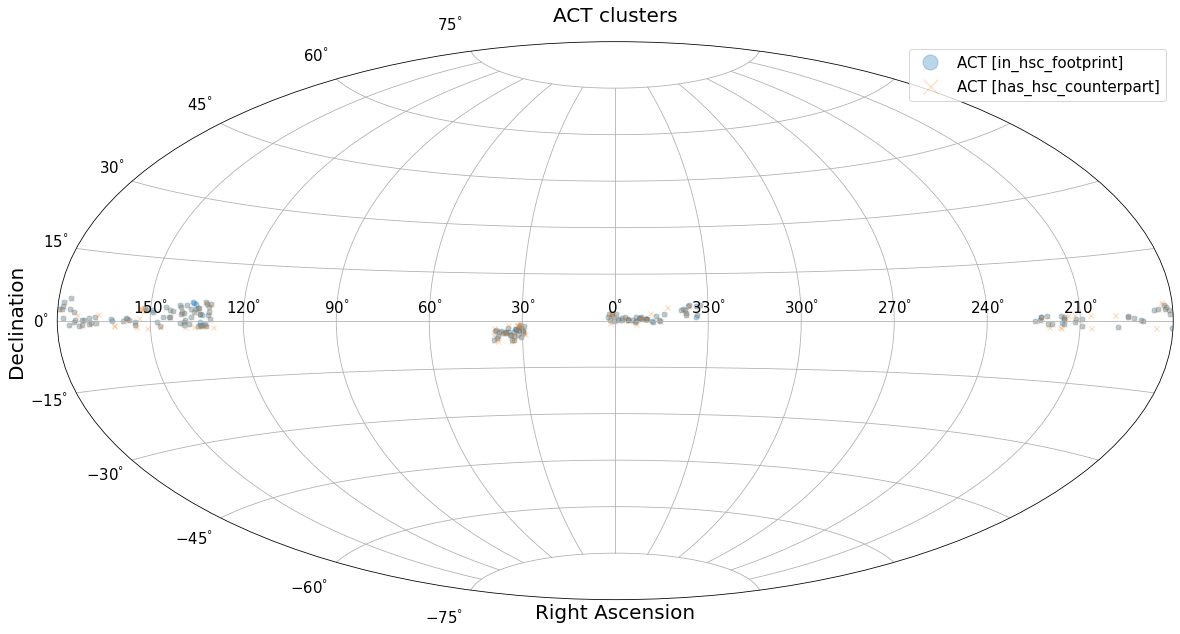

In [186]:
## ACT clusters flagged as being in HSC footprint and/or having an HSC counterpart

fig = plt.figure(figsize=(20,13))
fig.patch.set_facecolor('white')

ax = plt.subplot(111, projection="aitoff")
ax.grid(True)
# since the x-axis is reversed, we take the negative of the RA values
ax.plot(-act_ra[in_hsc_footprint], act_dec[in_hsc_footprint], 'o', markersize=5, alpha=0.3, \
        label='ACT [in_hsc_footprint]', zorder=1)
ax.plot(-act_ra[has_hsc_counterpart], act_dec[has_hsc_counterpart], 'x', markersize=5, alpha=0.3, \
        label='ACT [has_hsc_counterpart]', zorder=1)

ax.set_xlabel('Right Ascension', fontsize=20)
ax.set_ylabel('Declination', fontsize=20)
tick_labels_x = np.array([r'$150^\degree$', r'$120^\degree$', r'$90^\degree$', r'$60^\degree$', 
                        r'$30^\degree$', r'$0^\degree$', r'$330^\degree$', r'$300^\degree$',
                        r'$270^\degree$', r'$240^\degree$', r'$210^\degree$'])
tick_labels_y = np.array([r'$-75^\degree$', r'$-60^\degree$', r'$-45^\degree$', r'$-30^\degree$', 
                        r'$-15^\degree$', r'$0^\degree$', r'$15^\degree$', r'$30^\degree$',
                        r'$45^\degree$', r'$60^\degree$', r'$75^\degree$'])
ax.set_xticklabels(tick_labels_x, fontsize = 15, zorder = 5)
ax.set_yticklabels(tick_labels_y, fontsize = 15, zorder = 5)

ax.set_title("ACT clusters", pad=20, fontsize=20)
ax.legend(fontsize=15, markerscale=3)
#plt.savefig("Figures/Catalog_Props/ACT_HSC_catalogs_on_sky.png", bbox_inches='tight')
plt.show()

## Plot a random subset of ACT clusters

(playing around with matplotlib)

In [ ]:
# size = len(act_ra)
# rand_inds = np.random.uniform(size=size) > 0.98

# fig = plt.figure(figsize=(16,10))

# ax = plt.subplot(111, projection="aitoff")
# ax.set_facecolor('#C3FFFF')
# plt.grid(True)
# # unicode 00a9 = copyright symbol
# plt.plot(act_ra[rand_inds], act_dec[rand_inds], marker='$\u00A9$', 
#          markersize=20, linestyle='None', alpha=0.5, label='ACT', c='r')

# plt.title("Random ~2% of ACT galaxy clusters", pad=25)
# plt.show()

## Plot ACT clusters cross-matched with HSC, SDSS, and/or DES

In [ ]:
## Separate RM clusters based on if they have a counterpart:
# 1. only in one catalog,
# 2. in two catalogs, or 
# 3. in all three

has_hsc_counterpart = ACT_cat['CAMIRA']
has_sdss_counterpart = ACT_cat['RM'] 
has_des_counterpart = ACT_cat['RMDESY3']
print('Number of ACT clusters cross-matched with CAMIRA (HSC): ' + 
      str(np.sum(has_hsc_counterpart)))
print('Number of ACT clusters cross-matched with redMaPPer (SDSS and/or DES): ' + 
      str(np.sum(has_sdss_counterpart | has_des_counterpart)))
print('Number of ACT clusters cross-matched with at least one of the catalogs: ' + 
      str(np.sum(has_hsc_counterpart | has_sdss_counterpart | has_des_counterpart)))

print()

hsc_only = has_hsc_counterpart & (~has_sdss_counterpart) & (~has_des_counterpart)
sdss_only = (~has_hsc_counterpart) & has_sdss_counterpart & (~has_des_counterpart)
des_only = (~has_hsc_counterpart) & (~has_sdss_counterpart) & has_des_counterpart

hsc_sdss = has_hsc_counterpart & has_sdss_counterpart & (~has_des_counterpart)
sdss_des = (~has_hsc_counterpart) & has_sdss_counterpart & has_des_counterpart
hsc_des = has_hsc_counterpart & (~has_sdss_counterpart) & has_des_counterpart

hsc_sdss_des = has_hsc_counterpart & has_sdss_counterpart & has_des_counterpart

# 3-group Venn diagram showing #s of clusters in each category
from matplotlib_venn import venn3_unweighted

# order of subsets: A, B, AB, C, AC, BC, ABC
subsets = (np.sum(hsc_only), np.sum(sdss_only), np.sum(hsc_sdss), \
          np.sum(des_only), np.sum(hsc_des), np.sum(sdss_des), \
          np.sum(hsc_sdss_des))

plt.figure(figsize=(7,7))
plt.title("Numbers of ACT clusters cross-matched with HSC, SDSS, and/or DES")
venn3_unweighted(subsets = subsets, \
      set_labels = ('HSC (CAMIRA)', 'SDSS (RM)', 'DES (RM)'), \
      alpha = 0.5)

plt.savefig("Figures/Catalog_Props/HSC_SDSS_DES_Venn.png", bbox_inches='tight')
plt.show()

In [ ]:
## Plot the different subsets

plt.figure(figsize=(20,13))

plt.subplot(111, projection="aitoff")
plt.grid(True)

plt.plot(act_ra[hsc_only], act_dec[hsc_only], 
         'o', markersize=3, alpha=0.5, label='HSC only')
plt.plot(act_ra[sdss_only], act_dec[sdss_only], 
         'v', markersize=3, alpha=0.5, label='SDSS only')
plt.plot(act_ra[des_only], act_dec[des_only], 
         's', markersize=3, alpha=0.5, label='DES only')

plt.plot(act_ra[hsc_sdss], act_dec[hsc_sdss], 
         '|', markersize=5, alpha=0.5, label='HSC+SDSS')
plt.plot(act_ra[hsc_des], act_dec[hsc_des], 
         'x', markersize=5, alpha=0.5, label='HSC+DES')
plt.plot(act_ra[sdss_des], act_dec[sdss_des], 
         '1', markersize=5, alpha=0.5, label='SDSS+DES')

plt.plot(act_ra[hsc_sdss_des], act_dec[hsc_sdss_des], 
         '*', markersize=5, alpha=0.5, label='All 3')

plt.xlabel('Right Ascension', fontsize=12)
plt.ylabel('Declination', fontsize=12)

plt.title("ACT clusters cross-matched with HSC, SDSS, and/or DES", pad=40)
plt.legend(fontsize=12, markerscale=3)
plt.show()